In [25]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.datasets import cifar10 # type: ignore

In [26]:
#Load CIFAR-10
(x_train, y_train), (_, _) = cifar10.load_data()

In [27]:
# Normalize to [-1, 1] for tanh activation
x_train = (x_train.astype("float32") - 127.5) / 127.5
y_train = y_train.reshape(-1)

In [28]:
#Define Model Parameters

num_classes = 10
image_shape = (32, 32, 3)
noise_dim = 100

In [29]:
def build_generator():
    noise = layers.Input(shape=(noise_dim,))
    label = layers.Input(shape=(1,), dtype='int32')

    label_embedding = layers.Embedding(num_classes, noise_dim)(label)
    label_embedding = layers.Flatten()(label_embedding)
    combined_input = layers.multiply([noise, label_embedding])

    x = layers.Dense(2*2*512, activation="relu")(combined_input)
    x = layers.Reshape((2, 2, 512))(x)
    x = layers.Conv2DTranspose(256, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(x)

    return tf.keras.Model([noise, label], x)


In [30]:
def build_discriminator():
    img = layers.Input(shape=image_shape)
    label = layers.Input(shape=(1,), dtype='int32')

    label_embedding = layers.Embedding(num_classes, np.prod(image_shape))(label)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Reshape(image_shape)(label_embedding)

    combined_input = layers.Concatenate()([img, label_embedding])

    x = layers.Conv2D(64, 3, strides=2, padding='same')(combined_input)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model([img, label], x)


In [31]:
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

noise_input = layers.Input(shape=(noise_dim,))
label_input = layers.Input(shape=(1,))
generated_image = generator([noise_input, label_input])

discriminator.trainable = False
validity = discriminator([generated_image, label_input])

cgan = tf.keras.Model([noise_input, label_input], validity)
cgan.compile(loss='binary_crossentropy', optimizer='adam')


In [32]:
def train(epochs, batch_size=64):
    for epoch in range(epochs):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_imgs = x_train[idx]
        real_labels = y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        fake_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        fake_imgs = generator.predict([noise, fake_labels], verbose=0)

        d_loss_real = discriminator.train_on_batch([real_imgs, real_labels], np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch([fake_imgs, fake_labels], np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        sampled_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        g_loss = cgan.train_on_batch([noise, sampled_labels], np.ones((batch_size, 1)))

        if epoch % 100 == 0:
            print(f"Epoch {epoch} | D loss: {d_loss[0]:.4f}, D acc: {d_loss[1]:.2f} | G loss: {g_loss:.4f}")


In [33]:
train(epochs=10000, batch_size=64)

Epoch 0 | D loss: 0.7034, D acc: 0.41 | G loss: 0.6930
Epoch 100 | D loss: 1.7789, D acc: 0.18 | G loss: 0.1345
Epoch 200 | D loss: 2.0017, D acc: 0.18 | G loss: 0.0795
Epoch 300 | D loss: 2.0909, D acc: 0.18 | G loss: 0.0603
Epoch 400 | D loss: 2.1407, D acc: 0.18 | G loss: 0.0505
Epoch 500 | D loss: 2.1724, D acc: 0.18 | G loss: 0.0445
Epoch 600 | D loss: 2.1937, D acc: 0.18 | G loss: 0.0405
Epoch 700 | D loss: 2.2098, D acc: 0.18 | G loss: 0.0377
Epoch 800 | D loss: 2.2226, D acc: 0.18 | G loss: 0.0355
Epoch 900 | D loss: 2.2330, D acc: 0.18 | G loss: 0.0337
Epoch 1000 | D loss: 2.2424, D acc: 0.18 | G loss: 0.0323
Epoch 1100 | D loss: 2.2504, D acc: 0.18 | G loss: 0.0311
Epoch 1200 | D loss: 2.2571, D acc: 0.18 | G loss: 0.0301
Epoch 1300 | D loss: 2.2628, D acc: 0.18 | G loss: 0.0293
Epoch 1400 | D loss: 2.2677, D acc: 0.18 | G loss: 0.0286
Epoch 1500 | D loss: 2.2720, D acc: 0.18 | G loss: 0.0280
Epoch 1600 | D loss: 2.2762, D acc: 0.18 | G loss: 0.0274
Epoch 1700 | D loss: 2.280

In [34]:
generator.save("cgan_generator_cifar10.keras")

In [35]:
from tensorflow.keras.models import load_model
generator = load_model("cgan_generator_cifar10.keras")

In [36]:
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                 'dog', 'frog', 'horse', 'ship', 'truck']

def generate_images(class_name, num_images=5):
    if class_name not in cifar_classes:
        print("Invalid class name.")
        return
    class_idx = cifar_classes.index(class_name)
    noise = np.random.normal(0, 1, (num_images, noise_dim))
    labels = np.full((num_images, 1), class_idx)

    gen_imgs = generator.predict([noise, labels], verbose=0)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]

    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(gen_imgs[i])
        plt.axis('off')
    plt.suptitle(f"Generated Images of '{class_name}'")
    plt.show()


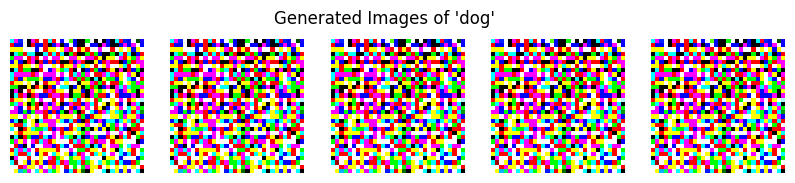

In [46]:
user_input = input("Enter class name: ").strip().lower()
generate_images(user_input)